# Starbucks Capstone Challenge
### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine lea
rning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

def column_mapper(data, column_name):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in data[column_name]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(coded_dict[val])
        
    return encoded

profile['person_id'] = column_mapper(profile, 'id')
portfolio['portfolio_id'] = column_mapper(portfolio, 'id')

# breaking down value
values = transcript['value'].apply(pd.Series)
transcript = pd.concat([transcript, values], axis=1)
transcript.drop('value', axis = 1)

# concat offer_id with offer id
transcript['offer_id'] = transcript['offer_id'].replace(np.nan, '', regex=True)
transcript['offer id'] = transcript['offer id'].replace(np.nan, '', regex=True)
transcript['offer_id'] = transcript['offer_id'] + transcript['offer id']
transcript.drop('offer id', axis = 1, inplace = True)

# merge everything
transcript_profile = pd.merge(transcript, profile, how='left', left_on='person', right_on='id').drop('id', axis = 1)
df = pd.merge(transcript_profile, portfolio, how='left', left_on='offer_id', right_on='id').drop('id', axis = 1)
df.drop(['reward_x', 'value'], axis = 1, inplace = True)

# breaking down channels into 0 and 1
channels = df['channels'].apply(pd.Series).rename(columns={0: "web", 1: "email", 2: "mobile", 3: "social"})
df = pd.concat([df, channels], axis=1).drop('channels', axis = 1)
for column in ['web', 'email', 'mobile', 'social']:
    df[column] = df.apply(lambda x: 0 if pd.isna(x[column]) == pd.isna(np.nan) else 1, axis = 1)
    
# getting membership duration in months
df['membership_length'] = pd.to_datetime("today") - pd.to_datetime(df['became_member_on'], format='%Y%m%d')
df['membership_length'] = df['membership_length']/np.timedelta64(1, 'M')
df.drop(['person', 'offer_id', 'became_member_on'], axis = 1, inplace = True)
df.head()

,event,time,amount,age,gender,income,person_id,difficulty,duration,offer_type,reward_y,portfolio_id,web,email,mobile,social,membership_length
0,offer received,0,NaN,75,F,100000.0,4,5.0,7.0,bogo,5.0,4.0,1,1,1,0,43.072914
1,offer received,0,NaN,118,None,NaN,5,20.0,10.0,discount,5.0,5.0,1,1,0,0,40.214539
2,offer received,0,NaN,68,M,70000.0,6,10.0,7.0,discount,2.0,10.0,1,1,1,0,31.507995
3,offer received,0,NaN,118,None,NaN,7,10.0,10.0,discount,2.0,7.0,1,1,1,1,38.506085
4,offer received,0,NaN,118,None,NaN,8,10.0,5.0,bogo,10.0,2.0,1,1,1,1,38.276101


# EDA

In [3]:
# Age destribution
profile['age'].value_counts(bins = 10).sort_index()

(17.898999999999997, 28.0]    1445
(28.0, 38.0]                  1473
(38.0, 48.0]                  2170
(48.0, 58.0]                  3503
(58.0, 68.0]                  3108
(68.0, 78.0]                  1907
(78.0, 88.0]                   895
(88.0, 98.0]                   302
(98.0, 108.0]                   22
(108.0, 118.0]                2175
Name: age, dtype: int64

In [4]:
# Age, income summary
profile[['age', 'income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [5]:
# nulls
profile.isnull().sum() / profile.shape[0]

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
person_id           0.000000
dtype: float64

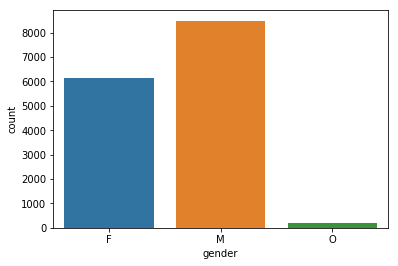

In [6]:
# plt.hist(profile['gender'].dropna())
# plt.xlabel('Gender')
# plt.show()

# Gender destribution
sns.countplot(profile['gender'].dropna())
plt.show()

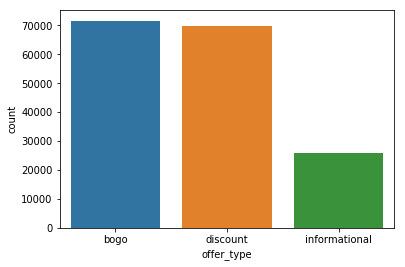

In [7]:
# offer type destribution
sns.countplot(df['offer_type'].dropna())
plt.show()

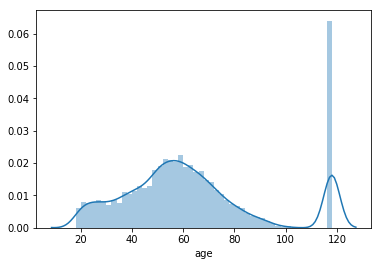

In [8]:
# plt.hist(profile['age'].dropna(), bins = 40)
# plt.xlabel('Age')
# plt.show()

# Age distribution
sns.distplot(profile['age'], kde = True, bins = 50)
plt.show()

In [9]:
# # filtering technique
# age_lower = profile['age'] > 50
# age_upper = profile['age'] < 70
# profile[age_lower & age_upper].describe()

In [10]:
# offer status destribution
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

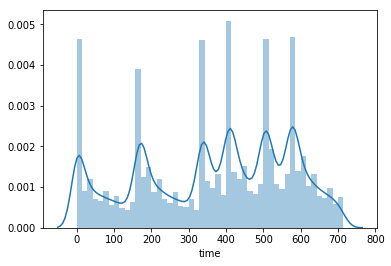

In [11]:
# fig, ax = plt.subplots()
# ax.hist(transcript['time'], bins = 50)
# plt.show()

# plt.hist(transcript['time'], bins = 50)
# plt.xlabel('time')
# plt.show()

sns.distplot(transcript['time'], kde = True, bins = 50)
plt.show()

In [12]:
df.isnull().sum()

event                     0
time                      0
amount               167581
age                       0
gender                33772
income                33772
person_id                 0
difficulty           138953
duration             138953
offer_type           138953
reward_y             138953
portfolio_id         138953
web                       0
email                     0
mobile                    0
social                    0
membership_length         0
dtype: int64

In [13]:
# creating df_offer_received (['offer received', 'offer completed']) for creating create_user_item_matrix
df_offer_received = df[df['event'].isin(['offer received', 'offer completed'])]

# creating df_offer_offer_viewed to not recommend the viewed and not received offers again to avoid redundancy
df_offer_offer_viewed = df[df['event'].isin(['offer viewed'])]

In [14]:
# create the user-offer matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with offer_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and offer ids on the columns with 1 values where a user interacted with 
    an offer and a 0 otherwise
    '''
    user_items = df_offer_received[['person_id', 'portfolio_id']]
    user_item = user_items.groupby(by=['person_id', 'portfolio_id']).agg(lambda x: 1).unstack().fillna(np.nan)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [15]:
order_received_mat = np.matrix(user_item)
print(order_received_mat)

[[ nan  nan  nan ...,  nan  nan   1.]
 [ nan  nan   1. ...,  nan  nan  nan]
 [ nan  nan  nan ...,   1.  nan  nan]
 ..., 
 [ nan  nan   1. ...,   1.  nan  nan]
 [  1.   1.  nan ...,  nan  nan  nan]
 [ nan  nan   1. ...,  nan   1.  nan]]


In [16]:
np.count_nonzero(~np.isnan(order_received_mat))

63288

In [17]:
def FunkSVD(order_received_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    order_received_mat - (numpy array) a matrix with users as rows, orders as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    order_mat - (numpy array) a latent feature by order matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = order_received_mat.shape[0]
    n_orders = order_received_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(order_received_mat))
    
    # initialize the user and order matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    order_mat = np.random.rand(latent_features, n_orders)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-order pair
        for i in range(n_users):
            for j in range(n_orders):
                
                # if the rating exists
                if order_received_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and order latent features
                    diff = order_received_mat[i, j] - np.dot(user_mat[i, :], order_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*order_mat[k, j])
                        order_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        # print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        if(iteration==iters-1):
            print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, order_mat 

In [18]:
user_mat, order_mat = FunkSVD(order_received_mat, latent_features=10, learning_rate=0.1, iters=50)

Optimizaiton Statistics
Iterations | Mean Squared Error 
50 		 0.000018


In [19]:
print(np.dot(user_mat, order_mat))
print(order_received_mat)

[[ 1.00628148  1.00489219  0.99948394 ...,  1.00672872  1.00280563
   1.00194599]
 [ 1.02056941  1.02336508  1.0212929  ...,  1.02206971  1.0206482
   1.02027526]
 [ 1.01558059  1.01874199  1.00982545 ...,  1.01874955  1.01462958
   1.01286716]
 ..., 
 [ 1.00059361  1.00201645  0.99682474 ...,  1.00036957  0.99890106
   0.99843413]
 [ 1.00200404  1.00191348  0.99637134 ...,  1.00026143  0.99904142
   0.99794027]
 [ 1.0052242   1.00489073  1.00015075 ...,  1.00270426  1.0019469
   1.00055256]]
[[ nan  nan  nan ...,  nan  nan   1.]
 [ nan  nan   1. ...,  nan  nan  nan]
 [ nan  nan  nan ...,   1.  nan  nan]
 ..., 
 [ nan  nan   1. ...,   1.  nan  nan]
 [  1.   1.  nan ...,  nan  nan  nan]
 [ nan  nan   1. ...,  nan   1.  nan]]


In [ ]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by offers: 
                1's when a user has interacted with an offer, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered    
    '''
    # compute similarity of each user to the provided user
    dot_p_dic = {}
    for user in user_item.index:
        dot_p_dic[user] = np.dot(user_item.loc[user_id], user_item.loc[user])
        
    # sort by similarity
    sorted_dot_p_dic = sorted(dot_p_dic.items(), key=lambda kv: kv[1], reverse=True)

    # create list of just the ids
    sorted_ids = [key for key, value in sorted_dot_p_dic]
    
    # remove the own user's id
    sorted_ids.remove(user_id)
    most_similar_users = sorted_ids
       
    return most_similar_users # return a list of the users in order from most to least similar

In [ ]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

In [ ]:
def get_user_offer_ids(user_id, df=df_offer_received):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by offers: 
                1's when a user has interacted with an offer, 0 otherwise
    
    OUTPUT:
    portfolio_ids - (list) a list of the offer ids seen by the user
    
    Description:
    Provides a list of the portfolio_ids that have been received by the user
    '''
    portfolio_ids = list(np.unique(df_offer_received[df['person_id'] == user_id]['portfolio_id']))
    portfolio_ids.sort()
    portfolio_ids
    
    return portfolio_ids # return the ids and names

In [ ]:
def get_not_received_ids(user_id, df=df_offer_offer_viewed):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by offers: 
                1's when a user has interacted with an offer, 0 otherwise
    
    OUTPUT:
    portfolio_ids - (list) a list of the offer ids seen by the user
    
    Description:
    Provides a list of the portfolio_ids that have been ignored by the user
    '''
    portfolio_ids = list(np.unique(df_offer_offer_viewed[df['person_id'] == user_id]['portfolio_id']))
    portfolio_ids.sort()
    portfolio_ids
    
    return portfolio_ids # return the ids and names

In [ ]:
get_user_offer_ids(4)

In [ ]:
get_not_received_ids(5)

In [ ]:
def user_user_recs(user_id, m=3):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds offers the user hasn't seen before and provides them as recs
    Does this until m recommendations are found    
    '''
    recs = []
    sim_to_user_id = find_similar_users(user_id)

    for sim_user in sim_to_user_id:
        rec_ids = get_user_offer_ids(sim_user)
        for id_ in rec_ids:
            if id_ not in recs and id_ not in get_user_offer_ids(user_id) and id_ not in get_not_received_ids(user_id):
                recs.append(id_)
                if len(recs) >= 10:
                    break
        if len(recs) >= 10:
            break
    
    # return random.choice(recs[:m]) # return your recommendations for this user_id
    return recs[:m]

In [ ]:
print(f"The user 1 will get the following offers: {user_user_recs(1)}")

In [ ]:
print(f"The user 12 will get the following offers: {user_user_recs(12)}")

In [ ]:
print(f"The user 123 will get the following offers: {user_user_recs(123)}")

Users covered by the recommender

In [ ]:
len(np.unique(df_offer_received['person_id']))

The number of users

In [ ]:
len(profile)